In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from toolbox import wrappers
from toolbox import network_utilities
import repos_tools
import pandas as pd
import numpy as np
import scipy.stats

GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


Read network and mapping betwen gene IDs and symbols

In [2]:
id_mapping_file = '../../resources/PPI/geneid_to_symbol.txt'
network = wrappers.get_network('../../resources/PPI/Cheng2019/network.sif', only_lcc = True)
id_symbol = pd.read_csv(id_mapping_file, sep='\t', index_col='GeneID')
id_symbol = id_symbol.set_index(id_symbol.index.astype('str'))

From Andrew's manuscript on repurposing asthma drugs to AD:
> Approved drugs, or drugs in development, target the protein products of 15 of the 81 genes as identified using the ChEMBL database [28]. Among these are GRIN3A, PDE4D, and IL6R. The glutamate ionotropic NMDA receptor subunit NR3A is encoded by GRIN3A and has been previously associated with AD as targeted by an existing approved AD treatment, Memantine [29]. Phosphodiesterase-4 (PDE4) has been considered a promising target for treatment of AD and depression and functions as an existing target for current asthma medication [30], [31]. Asthma is the trait of interest in this study, thus we have focused on drugs shown to be effective in it’s treatment such as Roflumilast targeting PDE4D. Through the use of STRINGDB protein-protein interaction network we selected additional asthma drugs targeting proteins with scores >= 0.500 from those within our implicated list [27]. This included approved asthma drugs such as Salbutamol targeting beta-2 adrenergic receptor ADRB2, Montelukast targeting cysteinyl leukotriene receptor 1 CYSLTR1, and Fluticasone which targets the glucocorticoid receptor NR3C1.

In [3]:
%%bash
cat > ../../results/2021-09-02-asthma-drugs/asthma-drug-targets <<EOF
GRIN3A
PDE4D
IL6R
ADRB2
CYSLTR1
NR3C1
EOF

In [4]:
targets = wrappers.convert_to_geneid(file_name='../../results/2021-09-02-asthma-drugs/asthma-drug-targets', id_type='symbol', id_mapping_file=id_mapping_file)
d = id_symbol.loc[targets, 'Symbol'].to_dict()
D = {v: {k} for k, v in d.items()}
D

set()


{'IL6R': {'3570'},
 'CYSLTR1': {'10800'},
 'GRIN3A': {'116443'},
 'NR3C1': {'2908'},
 'ADRB2': {'154'},
 'PDE4D': {'5144'}}

In [5]:
AD_genes_knowledge = wrappers.convert_to_geneid(file_name='../../results/2021-07-01-high-conf-ADgenes/AD-genes-knowledge', id_type='symbol', id_mapping_file=id_mapping_file)
AD_genes_knowledge, AD_genes_knowledge_dropped = repos_tools.drop_genes_notin_network(AD_genes_knowledge, network)
AD_genes_HC = wrappers.convert_to_geneid(file_name='../../results/2021-07-01-high-conf-ADgenes/AD-genes-seed', id_type='symbol', id_mapping_file=id_mapping_file)
AD_genes_HC, AD_genes_HC_dropped = repos_tools.drop_genes_notin_network(AD_genes_HC, network)
AD_genes_HC_2plus = wrappers.convert_to_geneid(file_name='../../results/2021-07-01-high-conf-ADgenes/AD-genes-seed-2plus', id_type='symbol', id_mapping_file=id_mapping_file)
AD_genes_HC_2plus, AD_genes_HC_2plus_dropped = repos_tools.drop_genes_notin_network(AD_genes_HC_2plus, network)

{'MT-ND2', 'MT-ND1'}
{'ENSG00000260911', 'AC087500.1', 'FAM115D', 'MT-ND1', 'MT-ND2', 'RP11-385F7.1', 'RTFDC1', 'ENSG00000270081.1', 'AC099524.1', 'AL512631.1', 'CTD-2380F24.1', 'X84075'}
{'MT-ND2', 'MT-ND1'}


Calculate proximity

In [6]:
def helper(target, geneset, network):
    res = wrappers.calculate_proximity(network=network, nodes_from=target, nodes_to=geneset)
    return(res)

Res_knowledge = {k: helper(v, AD_genes_knowledge, network) for k, v in D.items()}
Res_HC = {k: helper(v, AD_genes_HC, network) for k, v in D.items()}
Res_HC_2plus = {k: helper(v, AD_genes_HC_2plus, network) for k, v in D.items()}

In [8]:
def dict2df(d, condition):
    l = [[v[0], v[1], v[2][0], v[2][1]] for v in d.values()]
    a = np.array(l)
    ix = pd.MultiIndex.from_product([[condition], d.keys()])
    # z = (d - mean_0) / std_0
    df = pd.DataFrame(a, columns=['d', 'z', 'mean_0', 'std_0'], index=ix)
    df['p'] = df['z'].apply(lambda x: scipy.stats.norm.sf(-x))
    df = df.rename_axis(['condition', 'target'], axis=0)
    return(df)

results = pd.concat([dict2df(Res_knowledge, condition='knowledge'),
                     dict2df(Res_HC_2plus, condition='HC 2+'),
                     dict2df(Res_HC, condition='HC')
                    ], axis=0)# write to a CSV file
results.to_csv('../../results/2021-09-02-asthma-drugs/proximity-results.csv')
results['condition'] = results.index.get_level_values('condition')
results['target'] = results.index.get_level_values('target')

results

d         z  mean_0     std_0         p  condition  \
condition target                                                          
knowledge IL6R     1.0 -3.071405   1.916  0.298235  0.001065  knowledge   
          CYSLTR1  4.0  2.836651   2.414  0.559110  0.997721  knowledge   
          GRIN3A   2.0  0.086253   1.976  0.278252  0.534367  knowledge   
          NR3C1    1.0 -0.671847   1.311  0.462903  0.250840  knowledge   
          ADRB2    2.0  1.572330   1.288  0.452831  0.942063  knowledge   
          PDE4D    1.0 -2.012618   1.804  0.399480  0.022077  knowledge   
HC 2+     IL6R     1.0 -2.163894   1.828  0.382643  0.015236      HC 2+   
          CYSLTR1  3.0  1.446822   2.251  0.517686  0.926027      HC 2+   
          GRIN3A   2.0  0.330668   1.876  0.374999  0.629552      HC 2+   
          NR3C1    1.0 -0.272239   1.069  0.253454  0.392719      HC 2+   
          ADRB2    1.0 -0.292876   1.079  0.269739  0.384808      HC 2+   
          PDE4D    1.0 -1.143245   1.584  0.510827  0.126469      HC 2+   
HC        IL6R     1.0 -1.855921   1.775  0.417582  0.031732         HC   
          CYSLTR1  3.0  1.490766   2.233  0.514501  0.931988         HC   
          GRIN3A   2.0  0.390399   1.847  0.391907  0.651879         HC   
          NR3C1    1.0 -0.172818   1.029  0.167806  0.431397         HC   
          ADRB2    1.0 -0.153432   1.023  0.149903  0.439029         HC   
          PDE4D    1.0 -0.914677   1.471  0.514936  0.180181         HC   

                    target  
condition target            
knowledge IL6R        IL6R  
          CYSLTR1  CYSLTR1  
          GRIN3A    GRIN3A  
          NR3C1      NR3C1  
          ADRB2      ADRB2  
          PDE4D      PDE4D  
HC 2+     IL6R        IL6R  
          CYSLTR1  CYSLTR1  
          GRIN3A    GRIN3A  
          NR3C1      NR3C1  
          ADRB2      ADRB2  
          PDE4D      PDE4D  
HC        IL6R        IL6R  
          CYSLTR1  CYSLTR1  
          GRIN3A    GRIN3A  
          NR3C1      NR3C1  
          ADRB2      ADRB2  
          PDE4D      PDE4D

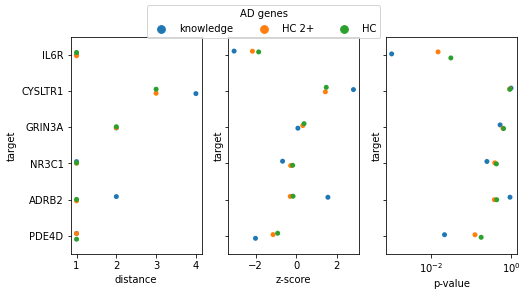

In [9]:
fig, ax = repos_tools.plot_proximity_results(results)

In [10]:
%connect_info

{
  "shell_port": 45307,
  "iopub_port": 44399,
  "stdin_port": 58407,
  "control_port": 51575,
  "hb_port": 55807,
  "ip": "127.0.0.1",
  "key": "ef866bd1-02007fb4e1921c4b94dbea88",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-1833b516-3394-435f-aa21-3a852f2f7e85.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
